In [1]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
large_train = pd.read_csv('./data/large_train_sample.csv')
cheap_train = pd.read_csv('./data/cheap_train_sample.csv')

In [3]:
large_train.shape

(32561, 14)

In [4]:
cheap_train.shape

(6513, 14)

In [5]:
full_train = pd.concat([large_train,cheap_train], ignore_index = True)

In [6]:
full_train.shape

(39074, 14)

In [7]:
full_train.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
wage              0
dtype: int64

In [8]:
full_train.drop(columns = ['education','native-country'], inplace = True)

In [9]:
full_train['fnlwgt'].nunique()
#nunique: Kehinde

21648

In [10]:
for x in full_train:
    if full_train[x].dtype == 'object':
        full_train[x] = full_train[x].str.strip()

In [11]:
full_train['wage'] = full_train['wage'].map({'>50K': 1, '<=50K': 0})

In [12]:
# full_train['Male'] = full_train['sex'].map({'Male': 1 , 'Female': 0})
# full_train['Female']  = full_train['sex'].map({'Male': 0 , 'Female': 1})

In [13]:
train_corr = full_train.corr()

In [14]:
train_corr

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,wage
age,1.000000,-0.078312,0.038272,0.077868,0.057300,0.070297,0.235328
fnlwgt,-0.078312,1.000000,-0.044329,-0.000937,-0.010517,-0.014559,-0.011700
education-num,0.038272,-0.044329,1.000000,0.123262,0.079255,0.148766,0.333186
capital-gain,0.077868,-0.000937,0.123262,1.000000,-0.031667,0.077626,0.223001
capital-loss,0.057300,-0.010517,0.079255,-0.031667,1.000000,0.052779,0.148090
hours-per-week,0.070297,-0.014559,0.148766,0.077626,0.052779,1.000000,0.233926
wage,0.235328,-0.011700,0.333186,0.223001,0.148090,0.233926,1.000000


In [15]:
for x in full_train.columns:
    print(f'{x} : {full_train[x].unique()}')

age : [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
workclass : ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
fnlwgt : [ 77516  83311 215646 ...  34066  84661 257302]
education-num : [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
marital-status : ['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation : ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship : ['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
sex : ['Male' 'Female']
capital-gain :

<AxesSubplot:>

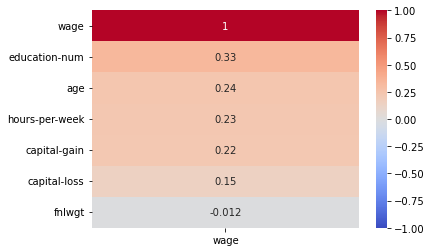

In [16]:
sns.heatmap(train_corr[['wage']].sort_values(by = 'wage', ascending=False), annot = True , vmin = -1, vmax = 1, cmap = 'coolwarm')

In [17]:
full_train['relationship'].value_counts()

Husband           15805
Not-in-family      9970
Own-child          6087
Unmarried          4147
Wife               1890
Other-relative     1175
Name: relationship, dtype: int64

In [18]:
full_train['marital-status']

0             Never-married
1        Married-civ-spouse
2                  Divorced
3        Married-civ-spouse
4        Married-civ-spouse
                ...        
39069    Married-civ-spouse
39070         Never-married
39071    Married-civ-spouse
39072         Never-married
39073    Married-civ-spouse
Name: marital-status, Length: 39074, dtype: object

In [19]:
single = ['Never-married','Divorced', 'Separated', 'Widowed']
full_train['marital-status_group'] = ["Single" if x in single else "Married" for x in full_train['marital-status']]

In [20]:
for x in full_train.columns:
    if full_train[x].dtype == 'object':
        print(f'{x} : {len(full_train[x].unique())} \n')

workclass : 9 

marital-status : 7 

occupation : 15 

relationship : 6 

sex : 2 

marital-status_group : 2 



In [21]:
objects = []
for x in full_train:
    if full_train[x].dtype == 'object':
        objects.append(x)

# Missing Occupation Model

In [22]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# getting the values into a list before turning into numbers
oc_list = full_train['occupation'].unique().tolist()
oc_list 
#---------
#https://stackoverflow.com/questions/36459969/how-to-convert-a-list-to-a-dictionary-with-indexes-as-values
oc_dict = {k:v for v,k in enumerate(oc_list) }
oc_dict

full_train['occupation_num'] = full_train['occupation'].map(oc_dict)

temp_ob = objects
temp_ob.append('occupation_num')

X = full_train.loc[full_train['occupation'] != '?', : ].drop(columns= temp_ob)
y = full_train.loc[full_train['occupation'] != '?', : ]['occupation_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

y.value_counts(normalize=True)
pipe =  Pipeline([
    ('sc', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

pipe_to_params = {
    "sc__with_mean":[True, False],
    "sc__with_std": [True, False],
    "knn__n_neighbors": [3,5,7,9],
    "knn__weights": ["uniform", "distance"]
}

knn_grid = GridSearchCV(
    pipe,
    param_grid=pipe_to_params,
    cv = 5,
    verbose=1
)

knn_grid.fit(X_train, y_train)

knn_grid.best_params_

knn_best = knn_grid.best_estimator_
knn_grid.best_score_
knn_best.score(X_train, y_train), knn_best.score(X_test, y_test)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


(0.997359759846649, 0.4168384506889443)

In [23]:
occupation_quest = full_train.loc[full_train['occupation_num'] == 11]
occupation_quest

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,wage,marital-status_group,occupation_num
27,54,?,180211,10,Married-civ-spouse,?,Husband,Male,0,0,60,1,Married,11
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,Male,0,0,40,0,Married,11
69,25,?,200681,10,Never-married,?,Own-child,Male,0,0,40,0,Single,11
77,67,?,212759,6,Married-civ-spouse,?,Husband,Male,0,0,2,0,Married,11
106,17,?,304873,6,Never-married,?,Own-child,Female,34095,0,32,0,Single,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38962,24,?,175069,13,Never-married,?,Not-in-family,Male,0,0,50,0,Single,11
38964,68,?,53850,4,Married-civ-spouse,?,Husband,Male,0,0,40,0,Married,11
39036,21,?,405684,9,Never-married,?,Other-relative,Male,0,0,35,0,Single,11
39060,67,?,37092,4,Married-civ-spouse,?,Husband,Male,0,0,4,0,Married,11


In [24]:
#my predictions for the ? in occupation.. my y preds
y_preds = knn_best.predict(occupation_quest.drop(columns=objects))
y_preds

array([1, 6, 4, ..., 4, 8, 4], dtype=int64)

# Missing Occupation Replacement

In [25]:
occupation_quest['predicted_occupation'] = y_preds

C:\Users\mshuba\AppData\Local\Temp/ipykernel_12900/2940446328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  occupation_quest['predicted_occupation'] = y_preds


In [26]:
occupation_quest

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,wage,marital-status_group,occupation_num,predicted_occupation
27,54,?,180211,10,Married-civ-spouse,?,Husband,Male,0,0,60,1,Married,11,1
61,32,?,293936,4,Married-spouse-absent,?,Not-in-family,Male,0,0,40,0,Married,11,6
69,25,?,200681,10,Never-married,?,Own-child,Male,0,0,40,0,Single,11,4
77,67,?,212759,6,Married-civ-spouse,?,Husband,Male,0,0,2,0,Married,11,4
106,17,?,304873,6,Never-married,?,Own-child,Female,34095,0,32,0,Single,11,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38962,24,?,175069,13,Never-married,?,Not-in-family,Male,0,0,50,0,Single,11,5
38964,68,?,53850,4,Married-civ-spouse,?,Husband,Male,0,0,40,0,Married,11,8
39036,21,?,405684,9,Never-married,?,Other-relative,Male,0,0,35,0,Single,11,4
39060,67,?,37092,4,Married-civ-spouse,?,Husband,Male,0,0,4,0,Married,11,8


In [27]:
full_train['predicted_?'] = occupation_quest['predicted_occupation']

In [28]:
full_train['dummi_oc_num'] = full_train['occupation_num']

In [29]:
full_train

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,sex,capital-gain,capital-loss,hours-per-week,wage,marital-status_group,occupation_num,predicted_?,dummi_oc_num
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,Male,2174,0,40,0,Single,0,NaN,0
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,Male,0,0,13,0,Married,1,NaN,1
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,Male,0,0,40,0,Single,2,NaN,2
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Male,0,0,40,0,Married,2,NaN,2
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Female,0,0,40,0,Married,3,NaN,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39069,29,Private,198997,9,Married-civ-spouse,Adm-clerical,Wife,Female,0,0,20,0,Married,0,NaN,0
39070,17,Private,46496,7,Never-married,Other-service,Own-child,Male,0,0,5,0,Single,4,NaN,4
39071,31,Local-gov,381153,10,Married-civ-spouse,Protective-serv,Husband,Male,15024,0,56,1,Married,12,NaN,12
39072,35,Private,385412,13,Never-married,Adm-clerical,Not-in-family,Female,0,0,40,0,Single,0,NaN,0


In [30]:
full_train['dummi_oc_num'] = np.where(full_train['dummi_oc_num'] == 11, full_train['predicted_?'], full_train['dummi_oc_num']) #statement.. if... else

In [31]:
full_train[['dummi_oc_num', 'occupation_num', 'predicted_?']]

,dummi_oc_num,occupation_num,predicted_?
0,0.0,0,NaN
1,1.0,1,NaN
2,2.0,2,NaN
3,2.0,2,NaN
4,3.0,3,NaN
...,...,...,...
39069,0.0,0,NaN
39070,4.0,4,NaN
39071,12.0,12,NaN
39072,0.0,0,NaN


In [32]:
full_train[['dummi_oc_num', 'occupation_num', 'predicted_?']].iloc[61:70]

,dummi_oc_num,occupation_num,predicted_?
61,6.0,11,6.0
62,7.0,7,NaN
63,3.0,3,NaN
64,10.0,10,NaN
65,6.0,6,NaN
66,0.0,0,NaN
67,0.0,0,NaN
68,1.0,1,NaN
69,4.0,11,4.0


In [33]:
rev_oc_dict = {}

for key, value in oc_dict.items():
    rev_oc_dict[value] = key
   
rev_oc_dict

{0: 'Adm-clerical',
 1: 'Exec-managerial',
 2: 'Handlers-cleaners',
 3: 'Prof-specialty',
 4: 'Other-service',
 5: 'Sales',
 6: 'Craft-repair',
 7: 'Transport-moving',
 8: 'Farming-fishing',
 9: 'Machine-op-inspct',
 10: 'Tech-support',
 11: '?',
 12: 'Protective-serv',
 13: 'Armed-Forces',
 14: 'Priv-house-serv'}

In [34]:
full_train['occupation_prime'] = full_train['dummi_oc_num'].map(rev_oc_dict) # Filled nans or ?

In [35]:
full_train[['dummi_oc_num', 'occupation_num', 'predicted_?', 'occupation_prime','occupation']].iloc[61:70]

,dummi_oc_num,occupation_num,predicted_?,occupation_prime,occupation
61,6.0,11,6.0,Craft-repair,?
62,7.0,7,NaN,Transport-moving,Transport-moving
63,3.0,3,NaN,Prof-specialty,Prof-specialty
64,10.0,10,NaN,Tech-support,Tech-support
65,6.0,6,NaN,Craft-repair,Craft-repair
66,0.0,0,NaN,Adm-clerical,Adm-clerical
67,0.0,0,NaN,Adm-clerical,Adm-clerical
68,1.0,1,NaN,Exec-managerial,Exec-managerial
69,4.0,11,4.0,Other-service,?


# Dummies

In [36]:
objects = []
for x in full_train:
    if full_train[x].dtype == 'object':
        objects.append(x)

In [37]:
objects.remove('occupation')

In [38]:
objects

['workclass',
 'marital-status',
 'relationship',
 'sex',
 'marital-status_group',
 'occupation_prime']

In [39]:
full_train_dum = pd.get_dummies(full_train[objects])

In [40]:
full_train.shape, full_train_dum.shape

((39074, 17), (39074, 40))

In [41]:
pd.set_option('display.max_columns', 500)
full_train_join = full_train.join(full_train_dum,rsuffix = 'dummi')

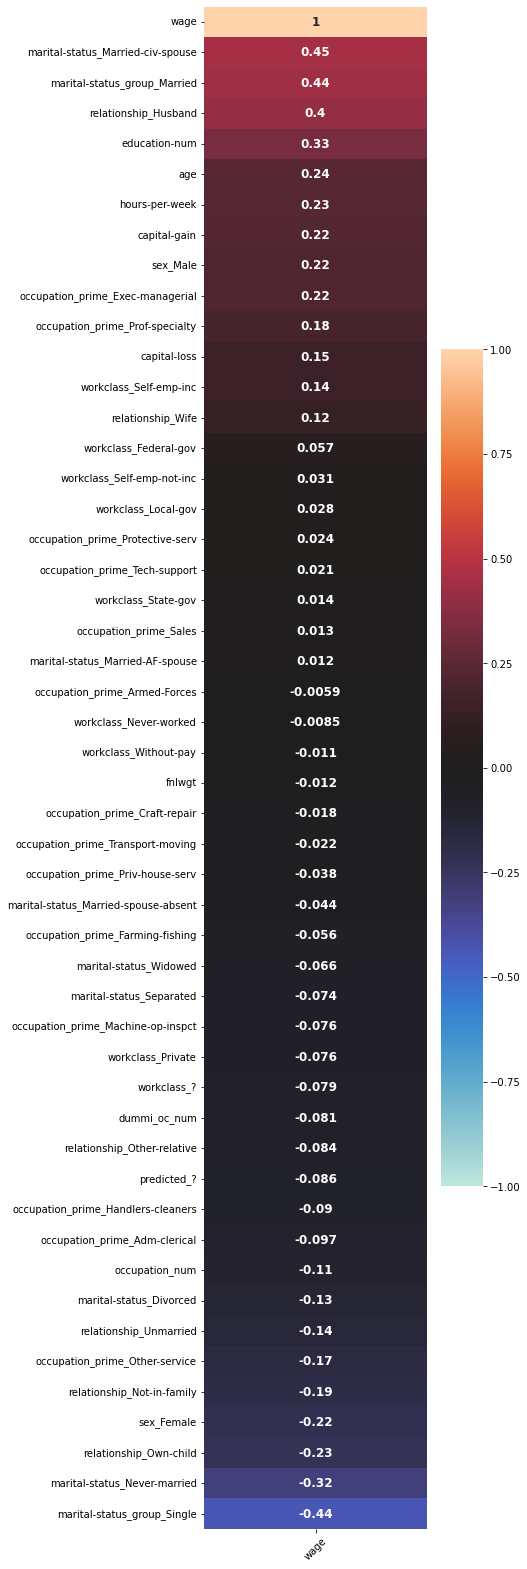

In [42]:
plt.figure(figsize= (5,28))

corr = full_train_join.corr()

sns.heatmap(corr[['wage']].sort_values(by='wage', ascending = False), annot=True, vmin=-1, vmax=1, cmap='icefire', annot_kws = {'size':12,'weight':'bold'})
plt.xticks(rotation=45);

In [43]:
full_train_join.corr()['wage'].abs().sort_values(ascending=False)[:30]

wage                                  1.000000
marital-status_Married-civ-spouse     0.445437
marital-status_group_Single           0.435463
marital-status_group_Married          0.435463
relationship_Husband                  0.403333
education-num                         0.333186
marital-status_Never-married          0.318155
age                                   0.235328
hours-per-week                        0.233926
relationship_Own-child                0.228390
capital-gain                          0.223001
sex_Male                              0.218203
sex_Female                            0.218203
occupation_prime_Exec-managerial      0.217937
relationship_Not-in-family            0.188069
occupation_prime_Prof-specialty       0.183255
occupation_prime_Other-service        0.169463
capital-loss                          0.148090
relationship_Unmarried                0.144311
workclass_Self-emp-inc                0.142066
marital-status_Divorced               0.127042
relationship_

In [44]:
full_train_dum.columns

Index(['workclass_?', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'marital-status_Divorced',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'relationship_Husband', 'relationship_Not-in-family',
       'relationship_Other-relative', 'relationship_Own-child',
       'relationship_Unmarried', 'relationship_Wife', 'sex_Female', 'sex_Male',
       'marital-status_group_Married', 'marital-status_group_Single',
       'occupation_prime_Adm-clerical', 'occupation_prime_Armed-Forces',
       'occupation_prime_Craft-repair', 'occupation_prime_Exec-managerial',
       'occupation_prime_Farming-fishing',
       'occupation_prime_Handlers-cleaners',

In [45]:
features = ['capital-gain',
     'hours-per-week',
     'age',
     'capital-loss',
     'education-num',
     'sex_Male',
     'marital-status_group_Married',
     'occupation_prime_Exec-managerial',
     'occupation_prime_Prof-specialty',
     'occupation_prime_Other-service',
     'relationship_Husband',
     'relationship_Own-child',
     'relationship_Not-in-family',
     'relationship_Unmarried', 
     'relationship_Wife']

In [46]:
len(features)

15

Modeling

Multinomial Naive Bayes

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV


In [48]:
X = full_train_join[features]
y = full_train_join['wage']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [50]:
mm = MinMaxScaler()   #NAIVE BAISE CANT USE NEGATIVE NUMBER SO YOU HAVE TO USE THIS ONE
M_train = mm.fit_transform(X_train)
M_test = mm.transform(X_test)

In [51]:
mnb = MultinomialNB()

In [52]:
params_dict = {'alpha': np.linspace(0,1,10)}

In [53]:
gs_mnb = GridSearchCV(estimator=mnb, param_grid=params_dict, cv = 5, verbose=1, n_jobs = -2)

In [54]:
%%time
gs_mnb.fit(M_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Wall time: 4.64 s


GridSearchCV(cv=5, estimator=MultinomialNB(), n_jobs=-2,
             param_grid={'alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])},
             verbose=1)

In [55]:
gs_mnb.best_params_

{'alpha': 1.0}

In [56]:
gs_mnb.best_score_

0.8229498738802633

In [57]:
gs_mnb.score(M_train, y_train) , gs_mnb.score(M_test, y_test)

(0.8223385156041102, 0.820860798759209)

# Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [60]:
logreg = LogisticRegression()

In [61]:
logreg.fit(Z_train,y_train)

LogisticRegression()

In [62]:
logreg.score(Z_train, y_train), logreg.score(Z_test, y_test)

(0.8472821727338706, 0.8454439705312137)

# Decision Trees

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [68]:
DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [69]:
pipe_tree =  Pipeline([
    ('sc', StandardScaler()),
    ('dt', DecisionTreeClassifier())
])


In [76]:
dtc_params = {
    'dt__max_depth': [7,8,9,10], 
    'dt__min_samples_split': [3,4,5],
    'dt__min_samples_leaf': [2,3], #[2,4,5] 
    'dt__ccp_alpha' : [0.0001, 0.00023, 0.00034, 0.00005]   
}

In [77]:
dtc_grid = GridSearchCV(
    pipe_tree,
    param_grid=dtc_params,
    cv = 5,
    verbose=1,
    n_jobs=2
)

In [78]:
dtc_grid.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=2,
             param_grid={'dt__ccp_alpha': [0.0001, 0.00023, 0.00034, 5e-05],
                         'dt__max_depth': [7, 8, 9, 10],
                         'dt__min_samples_leaf': [2, 3],
                         'dt__min_samples_split': [3, 4, 5]},
             verbose=1)

In [79]:
dtc_grid.best_params_

{'dt__ccp_alpha': 0.0001,
 'dt__max_depth': 10,
 'dt__min_samples_leaf': 2,
 'dt__min_samples_split': 3}

In [80]:
dtc_best = dtc_grid.best_estimator_

In [82]:
print("Best params: ", dtc_grid.best_params_)
print('Best score: ', dtc_grid.best_score_)

print("Train score: ", dtc_best.score(X_train, y_train))
print("Test score: ", dtc_best.score(X_test, y_test))


Best params:  {'dt__ccp_alpha': 0.0001, 'dt__max_depth': 10, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 3}
Best score:  0.857099216868305
Train score:  0.8653882883227014
Test score:  0.8578518805738659


In [83]:
9301/ (9301 + 489)

0.9500510725229826

In [84]:
(9301 + 1761)/ (9301 + 489 + 1344 + 1761)

0.8578518805738659

In [85]:
1761/ (1761 + 1344)

0.5671497584541063

In [86]:
#tn
9301 / (9301 + 489)

0.9500510725229826

In [87]:
1761 / (1761 + 489)

0.7826666666666666